# Chirp Sequence Isolation and Chirp Estimation

## Step 0: Load the utils

In [1]:
import Pkg;
Pkg.develop(path="../BatlabJuliaUtils")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [2]:
using BatlabJuliaUtils

[ Info: Precompiling BatlabJuliaUtils [f695e19e-85d4-4aa9-9313-fc4d39e48628]


In [106]:
## Some other packages

using Plots;
using Printf;
using MAT;
using Statistics;
using Roots;
using DataInterpolations;
using DSP;

## Step 1: Read in the audio data

In [5]:
y = readmicdata("../data/Pu166_01.mat");
# y = readmicdata("../data/Gr116_01.mat");

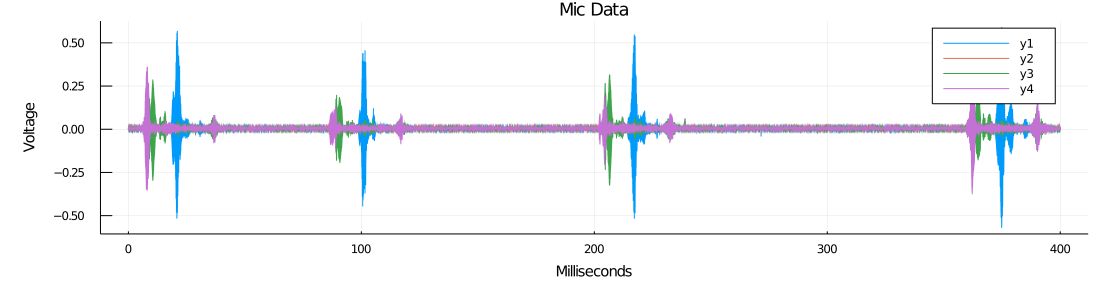

In [6]:
plotmicdata(1:100_000, y)

### Get a sample of noise for estimating the SNR

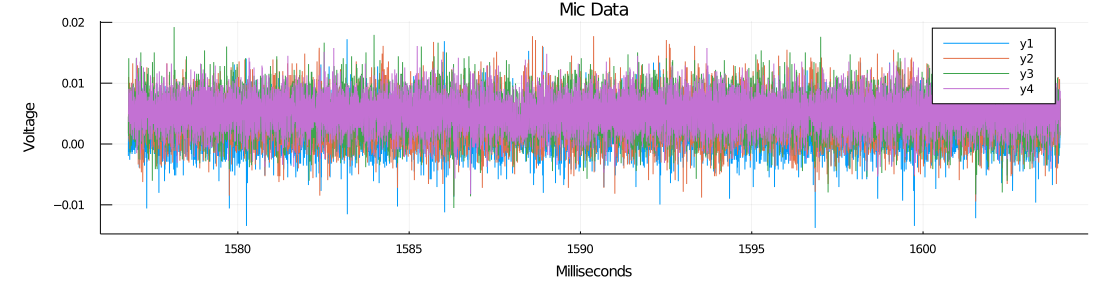

In [7]:
noise_sample_idxs = getnoisesampleidxs(y);
noise_sample = y[noise_sample_idxs, :];
plotmicdata(noise_sample_idxs, y)

You can see that the noise is not zero-mean, so let's subtract out the mean of the noise.

In [8]:
y = y .- mean(noise_sample; dims=1);
noise_sample = noise_sample .- mean(noise_sample; dims=1);

## Step 2: Determine which time segments have signal (for each mic)

### First, estimate the SNR

The next cell might take a minute or two.

In [9]:
snr = estimatesnr(y, noise_sample, window_size=128);

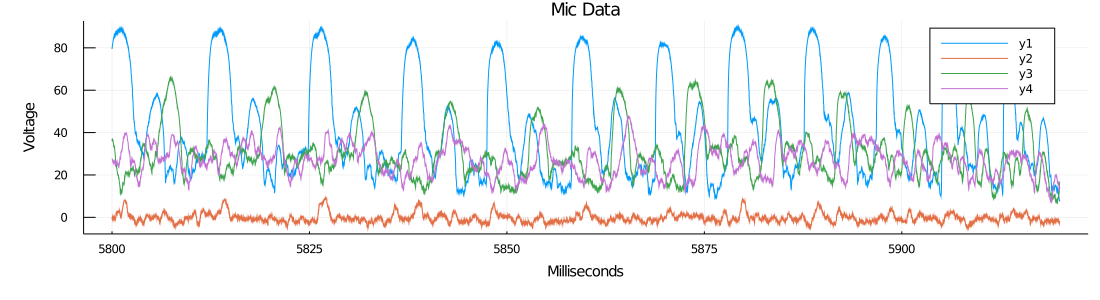

In [10]:
plotmicdata(1_450_000:1_480_000, snr)

### Next, set thresholds
30 db is considered "good SNR" for speech, so it makes sense to set the cutoff for what regions contain signal vs. noise around there. The SNR estimate is quite noisy, and we want to find contiguous regions that have signal, so let's look at regions where the estimated SNR is above the cutoff within some fraction of a millisecond from each point.

Also, there are some times that the SNR erroneously goes above 30, so we impose another constraint: at some point within the "signal region", the SNR must pass another, higher threshold. Let's choose 50.

In [11]:
### CONFIGURABLE PARAMETERS ###
SIGNAL_THRESH = 30
PEAK_THRESH = 50
# If a point is at most 0.5 milliseconds from a point where the SNR is over 30, then that point is
# considered part of a signal region
MAXFILTER_LENGTH_MS = 0.1
MAXFILTER_LENGTH = Int64(round(MAXFILTER_LENGTH_MS / 1000 * FS));

In [12]:
high_snr_locations = findhighsnrregions(snr, SIGNAL_THRESH, PEAK_THRESH, MAXFILTER_LENGTH);

Let's see how well the algorithm did! If there is any critical section of the data (e.g., buzz phase vocalizations), you can make sure that the algorithm didn't mess up anywhere.

Note that we will validate these sections by only keeping chirp sequences where at least 2 microphones agree on the vocalization time (computed using the location data), so it's ok if there are some erroneous chirp segments, or the algorithm thinks some echos are chirp segments.

In [13]:
## SET THESE VALUES
audio_idxs = 1:300_000;
audio_idxs = 1_450_000:1_480_000; # Buzz sequence for Pu166_01

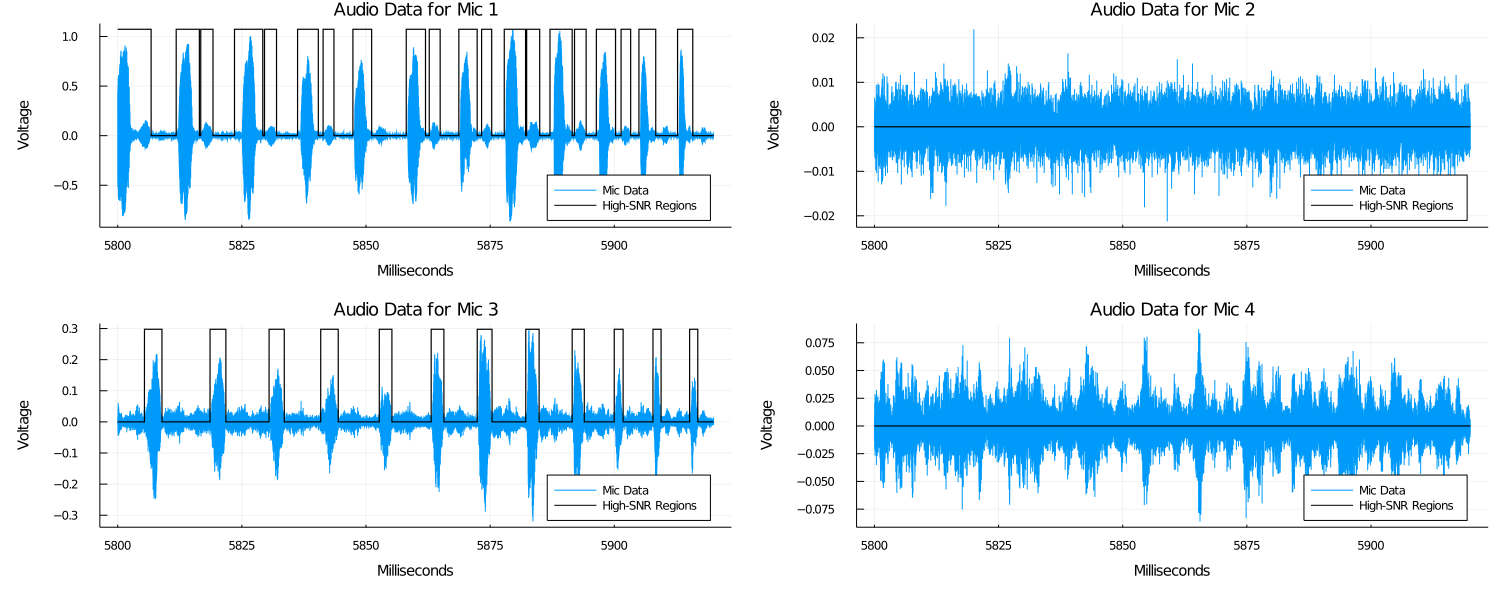

In [14]:
plots = Array{Plots.Plot}(undef, 4);
for mic=1:4
    plots[mic] = plotmicdata(audio_idxs, y[:, mic], label="Mic Data", title=(@sprintf "Audio Data for Mic %d" mic));
    plot!(audioindextoms.(audio_idxs), high_snr_locations[audio_idxs, mic]*maximum(y[audio_idxs,mic]), label="High-SNR Regions", color=:black, linewidth=1.2, legend=:bottomright);
end
plot(plots..., layout=grid(2, 2), size=(1500, 600), legend=:bottomright)

In [15]:
# Find the start and end indices of every high-SNR region
rough_seq_idxs_per_mic = Array{Matrix{Int64}}(undef, 4, 1);
for mic=1:4
    rough_seq_idxs_per_mic[mic] = findroughchirpsequenceidxs(snr, mic, SIGNAL_THRESH, PEAK_THRESH, MAXFILTER_LENGTH);
end

### Refine the ends of the chirp sequences

This method more or less gets the starts of chirp sequences, but it might cut off the end too early.

So, we adjust the end of the chirp sequence using the `adjustsequenceidxs` function, which uses a similar algorithm to `findhighsnrregions`, except with a lower SNR threshold and longer max filter size. It also automatically prevents end of the chirp sequence from going past the beginning of the next chirp sequence. 

In [16]:
### CONFIGURABLE PARAMETERS ###
TAIL_SNR_THRESH=20;
TAIL_MAXFILTER_LENGTH=50; # in samples

In [17]:
chirp_seq_idxs_per_mic = Array{Matrix{Int64}}(undef, 4, 1);
    for mic=1:4
        chirp_seq_idxs_per_mic[mic] = copy(rough_seq_idxs_per_mic[mic]);
    
        N_seqs = size(chirp_seq_idxs_per_mic[mic], 1);
        for row=1:N_seqs
            max_end_idx = (row == N_seqs) ? size(snr, 1) : chirp_seq_idxs_per_mic[mic][row+1, 1];
            chirp_seq_idxs_per_mic[mic][row, :] = 
                    adjustsequenceidxs(snr, mic, rough_seq_idxs_per_mic[mic][row, :],
                        max_end_idx, TAIL_SNR_THRESH, maxfilter_length=TAIL_MAXFILTER_LENGTH);
        end
    end

Let's verify that the chirp sequences produced are reasonable.

The algorithm might pick up a few echos and think that they are chirp sequences. This is expected; they should be filtered out once we require that two or more microphones "agree" on a chirp sequence.
It also might cut off the beginning of some chirp sequences if the beginning has very low SNR; we will compensate for this later.

Mic: 3, sequence number: 59


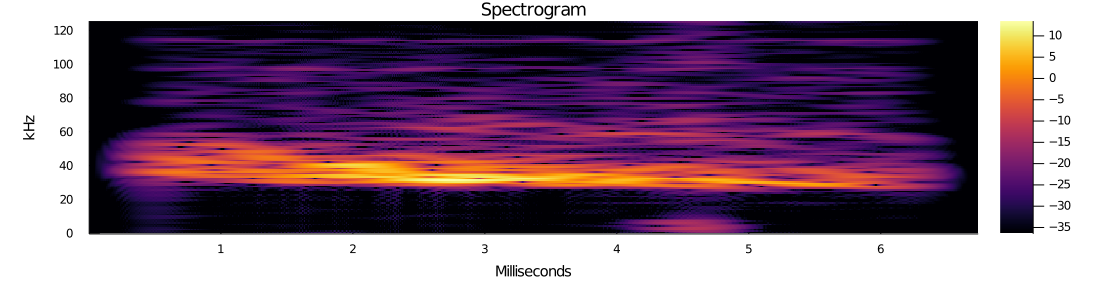

In [18]:
mic = 3;randint(4);
while size(chirp_seq_idxs_per_mic[mic], 1) == 0
    mic = randint(4);
end
seq_num = randint(size(chirp_seq_idxs_per_mic[mic], 1));
(@printf "Mic: %d, sequence number: %d\n" mic seq_num);

bounds = chirp_seq_idxs_per_mic[mic][seq_num, :];
plotSTFTtime(y[bounds[1]:bounds[2], mic], noverlap=255, zero_pad=true)

## Step 3: Determine chirp sequences that arose from the same initial bat vocalization

Now that we know (approximately) where the chirp sequences are, for each microphone, we can group them by which ones came from the same initial chirp. Also, for robustness, we only keep chirp sequences where two or more microphones "agree" on the initial vocalization time, or where the SNR is very high.

The vocalization time is calculated by interpolating the centroid data and solving for `t` in `distance_from_mic(t) = speed_of_sound * (time_chirp_reached_mic - t)`.

### Read in centroid and microphone data

In [19]:
centroid_mat = matread("../data/centroid/Pu166_001_centroidxyz.mat")
# centroid_mat = matread("../data/centroid/Gr116_05012023_001.mat")

Dict{String, Any} with 1 entry:
  "centroid_xyz_cted" => [NaN NaN … 2320.28 2320.28; NaN NaN … -1259.46 -1259.4…

In [20]:
centroids = Matrix(transpose(centroid_mat["centroid_xyz_cted"]))
centroids[end-9:end, :] # If this line errors, uncomment the following line
# centroids = centroid_mat["centroid_xyz_cted"]

10×3 Matrix{Float64}:
 2320.28  -1259.46  958.983
 2320.28  -1259.46  958.983
 2320.28  -1259.46  958.983
 2320.28  -1259.46  958.983
 2320.28  -1259.46  958.983
 2320.28  -1259.46  958.983
 2320.28  -1259.46  958.983
 2320.28  -1259.46  958.983
 2320.28  -1259.46  958.983
 2320.28  -1259.46  958.983

In [21]:
first_non_nan_idx = findfirst(.~isnan.(centroids[:, 1]));
(@printf "First time where the centroid data is not NaN: %d milliseconds\n" 1000*videoindextosec(first_non_nan_idx, size(centroids, 1)))

First time where the centroid data is not NaN: 5511 milliseconds


In [22]:
mic_positions_mat = matread("../data/mic_positions_fall2021.mat")
# mic_positions_mat = matread("../data/mic_positions_fall2023.mat")

Dict{String, Any} with 1 entry:
  "mic_pos1_2021" => [2911.36 -599.596 -7.00515 -2823.26; -594.18 -2886.39 2835…

In [23]:
mic_positions = Matrix(transpose(mic_positions_mat["mic_pos1_2021"]))

4×3 Matrix{Float64}:
  2911.36      -594.18   2267.79
  -599.596    -2886.39   2111.6
    -7.00515   2835.34   1442.65
 -2823.26       658.122  2326.58

### Run `groupchirpsequencesbystarttime` to determine which chirp sequences came from the same vocalization

In [24]:
### CONFIGURABLE PARAMETERS ###
TEMPORAL_TOLERANCE_MS = 1.5; #  if the estimated vocalization times for two
                             # chirp sequences (for different microphones) are
                             # within this number of milliseconds apart, they
                             # are considered to be from the same vocalization.

SINGLE_MIC_SNR_THRESH = 100; # if a chirp sequence only has data from only one
                             # microphone, still store the chirp sequence if it
                             # has an SNR over this value.

In [25]:
chirp_sequences, vocalization_times = 
        groupchirpsequencesbystarttime(chirp_seq_idxs_per_mic, snr, y, centroids,
            mic_positions, single_mic_snr_thresh=SINGLE_MIC_SNR_THRESH,
            vocalization_start_tolerance_ms=TEMPORAL_TOLERANCE_MS);

In [26]:
findfirst(vocalization_times .> 6000)

29

In [27]:
transpose(vocalization_times[8:28])

1×21 transpose(::Vector{Float64}) with eltype Float64:
 5761.98  5774.95  5787.3  5799.77  …  5942.42  5948.59  5954.91  5998.54

In [28]:
vocalization_times[8:28]

21-element Vector{Float64}:
 5761.983657012853
 5774.946409463041
 5787.30147822108
 5799.770114401935
 5812.308653867915
 5824.67914973064
 5835.51289867209
 5846.842920724526
 5857.419637494583
 5866.676800998666
 5876.213025539108
 5885.598541358424
 5894.165349638273
 5901.991455113761
 5909.354459431424
 5929.570624907783
 5935.821058179554
 5942.420014169161
 5948.5872646593325
 5954.914166526549
 5998.54194750457

Let's plot some chirp sequences!

Sequence number: 29


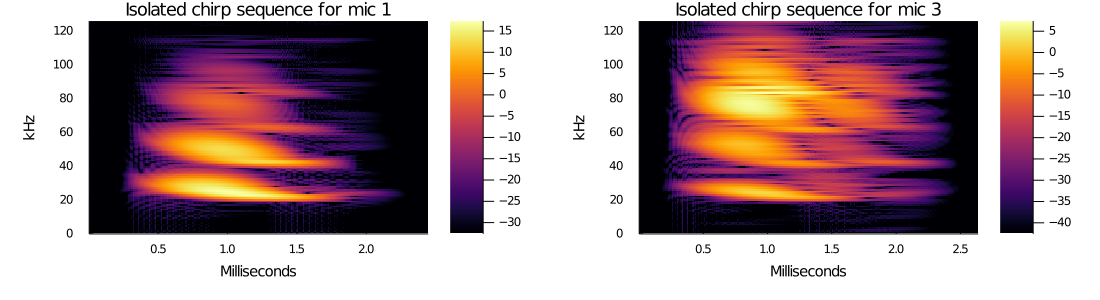

In [29]:
seq_idx = randint(length(chirp_sequences));
(@printf "Sequence number: %d\n" seq_idx);
plotchirpsequence(chirp_sequences[seq_idx], plot_spectrogram=true)

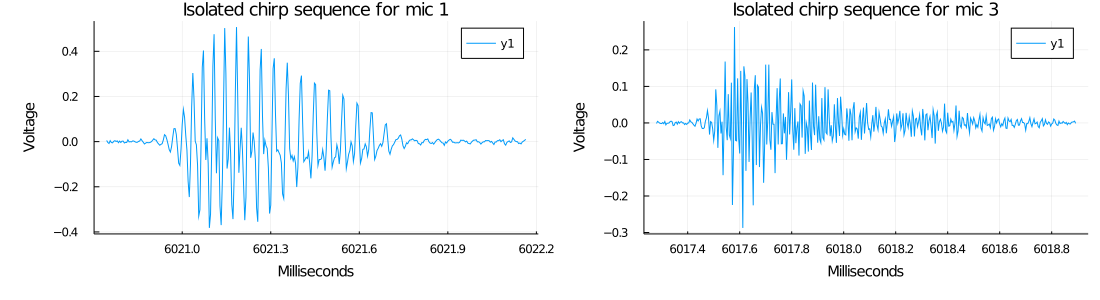

In [30]:
# you can plot in the time domain too
plotchirpsequence(chirp_sequences[seq_idx], plot_separate=true)

## Step 4: Estimate the "melody" of the vocalization

Now that we have sufficiently pre-processed the data, we can work towards estimating the original vocalization made by the bat.
We define the "melody" of the vocalization as the fundmental harmonic.

The first step is "tracing" the melody:
1. Find when the SNR goes over the `PEAK_THRESH`, and find the melody of the chirp at that point (here, the SNR is hopefully high enough to accurately estimate the melody).
2. Work backwards until the beginning of the chirp, at each index looking for the strongest frequency within some small range of the last frequency found.
3. Repeat, but this time work towards the end of the chirp. To avoid picking up echos, enforce that, once the slope of the melody (with respect to time) becomes negative, it can never become positive.
4. We have reached the end of the chirp when the tone drops off far enough from its maximum value.

After tracing the melody, we need to see if we found the fundamental harmonic
or some higher harmonic. This is done by taking the loudest part of the melody
and dividing the frequency by 2, 3, etc. until we go below 20 kHz. The fundamental harmonic is the lowest such frequency with power at most
`MELODY_DROP_THRESH_DB` below the loudest harmonic.

In [31]:
### CONFIGURABLE PARAMETERS ###
MAXIMUM_MELODY_SLOPE = 5; # this is the maximum amount, in Fourier transform
                          # indices, that the melody is allowed to change from
                          # one index to the next.
MELODY_DROP_THRESH_DB = 20; # described above

The next cell estimates the melody of a random chirp and plots it on top of the spectrogram in blue. It also plots the estimated end index of the chirp in cyan.

In [32]:
melody_kwargs = Dict{Symbol, Any}(
    :maximum_melody_slope => MAXIMUM_MELODY_SLOPE,
    :melody_drop_thresh_db => MELODY_DROP_THRESH_DB,
    :bandpass_filter => (20_000, 100_000)
);

In [33]:
import BatlabJuliaUtils.plotmelody
function plotmelody(chirp_seq_single_mic::ChirpSequence, melody::Vector{Int64}, chirp_bounds=nothing;
        nfft=256, bandpass_filter=(20_000, 100_000), melody_color="blue", end_color=1)
    pad_len = Int64(round(nfft/2));
    x = vcat(zeros(pad_len), chirp_seq_single_mic.mic_data, zeros(nfft-1-pad_len));
    Sx = stft(x, nfft, nfft-1, window=hamming(nfft));
    Sx = bandpassfilterspecgram(Sx, bandpass_filter[1], bandpass_filter[2], nfft=nfft);
    N = size(Sx, 2);
    
    p = plotSTFT(Sx, nfft=nfft, noverlap=nfft-1)
    plot!(audioindextoms.(1:N), fftindextofrequency.(melody, nfft) / 1000, linewidth=3, color=melody_color, label="Melody")
    if !isnothing(chirp_bounds)
        chirp_end = chirp_bounds[2];
        chirp_start = chirp_bounds[1];
        # plot a vertical line
        plot!(audioindextoms.([chirp_start, chirp_start]), [1, size(Sx, 1)], linewidth=5, color=end_color, label="Chirp bounds")
        plot!(audioindextoms.([chirp_end, chirp_end]), [1, size(Sx, 1)], linewidth=5, color=end_color, label=false)
    end
    return p;
end

plotmelody (generic function with 2 methods)

Sequence number: 19, mic: 1


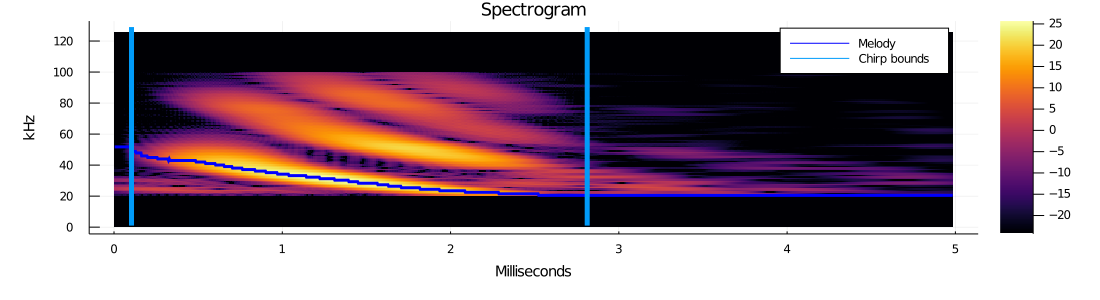

In [34]:
seq_idx = randint(length(chirp_sequences));
seq = chirp_sequences[seq_idx];
mic_idx = collect(keys(seq))[randint(length(seq))];

(@printf "Sequence number: %d, mic: %d\n" seq_idx mic_idx);
melody = findmelody(seq[mic_idx], PEAK_THRESH; melody_kwargs...);
chirp_bounds = estimatechirpbounds(seq[mic_idx], melody, PEAK_THRESH);
plotmelody(seq[mic_idx], melody, chirp_bounds)

We find harmonics by searching for the strongest frequency in a range around a multiple of the melody. This is more accurate than just saying that the harmonic is exactly some multiple of the fundamental frequency, especially since the melody might get cut off at lower frequencies.

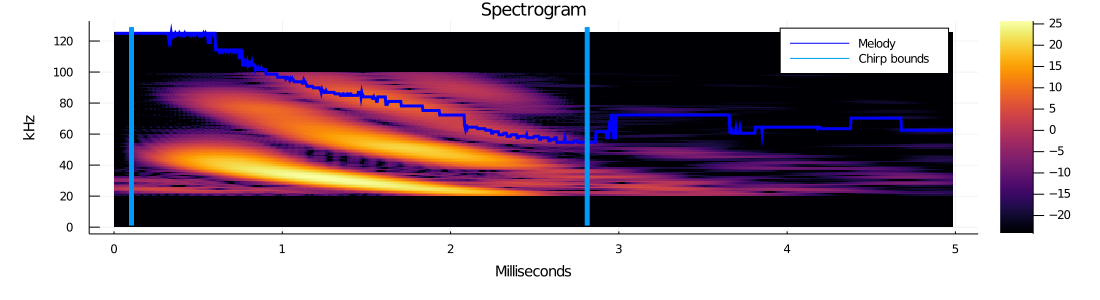

In [35]:
harmonic = getharmonic(seq[mic_idx], melody, 3, band_size=3);
plotmelody(seq[mic_idx], harmonic, chirp_bounds)

### Use the melody to semi-naively separate the chirp from the echos
1. Find the point where the melody is the strongest.
2. Find the first index, after this point, where the melody strength drops over
    `MELODY_DROP_THRESH_DB` decibels from its peak value (if this cutoff value
    is below `MELODY_THRESH_DB_LOW`, we instead find where the melody strength
    goes below `MELODY_THRESH_DB_LOW`).
    a. If the melody strength never drops below this threshold, then just return
        the last index of the chirp sequence.
3. Apply a moving average filter to the melody strength.
4. Apply the following heuristic:
    - The end of the chirp is the first local minimum of the melody strength
    after the index from step 2, or the first time the melody strength dips
    below `melody_thresh_db_low`, whichever comes first.
    - If neither event happens, return the last index of the chirp sequence.

In [36]:
### CONFIGURABLE PARAMETERS ###
# (parameters are described in the text above)
MELODY_THRESH_DB_LOW = -20;
MOVING_AVG_SIZE = 10;
MELODY_THRESH_DB_START = -10; # the start index of the chirp is
                              # computed as the first index where
                              # the melody strength passes this threshold.
                              # It usually works best when this is a bit
                              # above the MELODY_THRESH_DB_LOW.

In [37]:
chirp_bound_kwargs = Dict{Symbol, Any}(
    :melody_drop_thresh_db => MELODY_DROP_THRESH_DB,
    :melody_thresh_db_low => MELODY_THRESH_DB_LOW,
    :melody_thresh_db_start => MELODY_THRESH_DB_START,
    :moving_avg_size => MOVING_AVG_SIZE
);
chirp_kwargs = merge(melody_kwargs, chirp_bound_kwargs);

The next cell plots the estimated chirps (for a random chirp sequence) on top of the full chirp sequences. 

Sequence number: 23
Chirp Lengths (ms): [1.6720000000000002, 1.276]


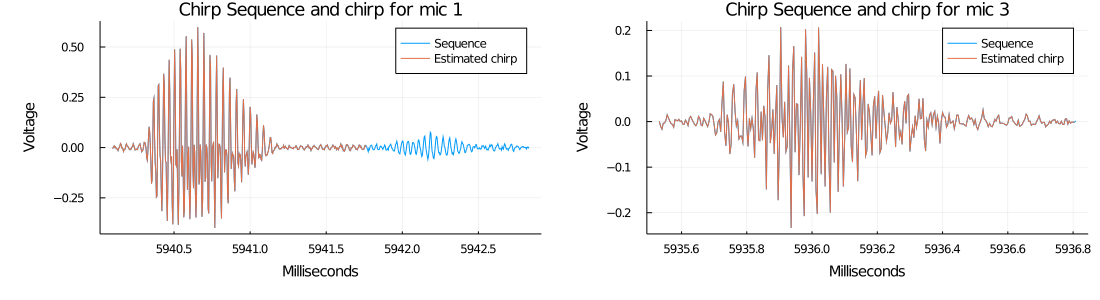

In [38]:
seq_idx = randint(length(chirp_sequences));
(@printf "Sequence number: %d\n" seq_idx);
seq = chirp_sequences[seq_idx];
plotestimatedchirps(seq, PEAK_THRESH; chirp_kwargs...)

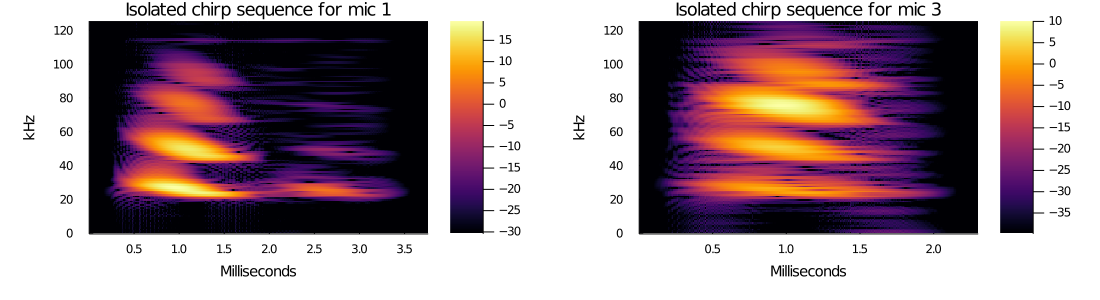

In [39]:
plotchirpsequence(chirp_sequences[seq_idx], plot_spectrogram=true)

### Aligning Chirps

You may notice that for Pu166/168 data, especially with mic 3, the beginnings of the chirps are often cut off due to low SNR. The parts that are cut off have such low SNR that we can't do anything with them, but it will matter in Step 5 that chirps from all microphones can be temporally aligned with each other.

So, we zero-pad the beginnings of those sequences such that that they are aligned chirp sequences from the other mics.

You can run the next few cells to see this in action, and look at `computemelodyoffsets` for more information.

In [40]:
seq_idx = randint(length(chirp_sequences));
(@printf "Sequence number: %d\n" seq_idx);
offsets = computemelodyoffsets(chirp_sequences[seq_idx], PEAK_THRESH; chirp_kwargs...)

Sequence number: 15


Dict{Int64, Int64} with 2 entries:
  3 => 97
  1 => 0

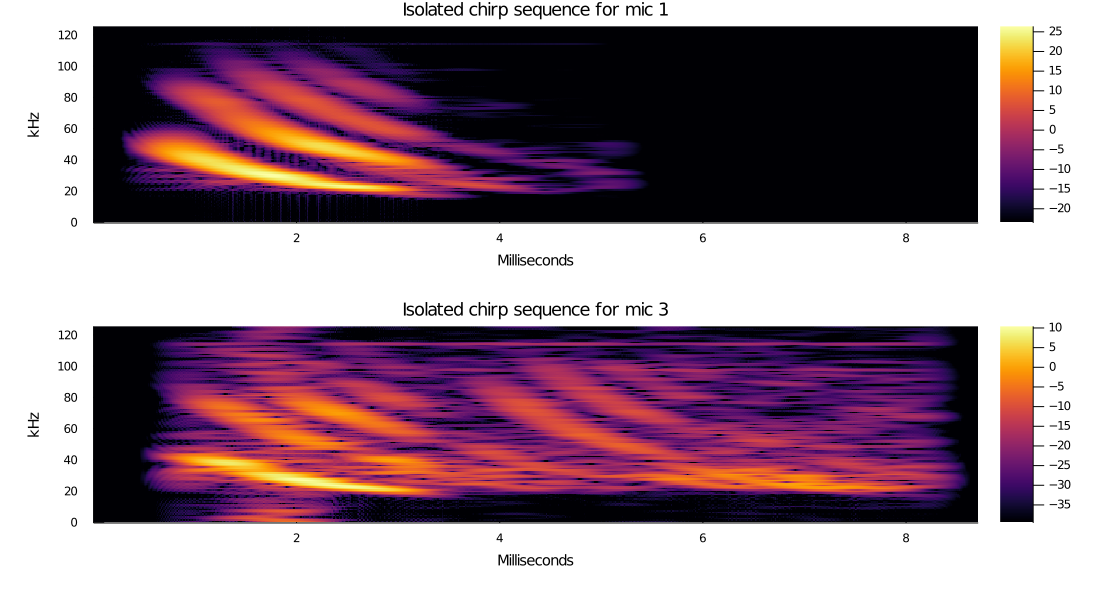

In [41]:
plotoffsetchirps(chirp_sequences[seq_idx], offsets, getchirpstartandendindices(chirp_sequences[seq_idx], PEAK_THRESH; chirp_kwargs...)[1])

## Step 5: Use optimization to combine information from all microphones and estimate the actual bat vocalization

We can combine the data from different microphones through **blind deconvolution**, which involves estimating:

1. The actual bat vocalization, $\mathbf{x}$, that produced a given chirp sequence
2. A set of impulse responses $\mathbf{h}_k$ such that, if $\mathbf{y}_k$ is the data from microphone $k$ for the chirp sequence, the convolution relation $\mathbf{x} * \mathbf{h}_k \approx \mathbf{y}_k$ holds.

We don't have enough information to solve the problem, unless we make some assumptions about the vocalization and the impulse response. We assume the following:

1. The impulse responses should be somewhat sparse (most elements are mostly zero). Intuatively, it should be nonzero at the beginning of the chirp sequence and at the locations of echos.
2. The melody estimation from the previous section was relatively accurate. So, we can expect most of the energy of the spectrogram of the chirp to be at harmonics of the melody

### Utility of this section

The previous sections do pretty well at estimating vocalizations, and the optimization algorithm doesn't do too much better. It can typically remove echos from estimated chirps and clean up some spectral noise, but it does occasionally introduce spectral noise.

This section can be seen as an interesting theoretical extension: formulating echo denoising as a blind deconvolution problem and jointly computing the initial vocalization and the impulse responmse mapping the vocalization to each microphone.

### Optimization problem formulation

Overall, we want to optimize the following things:

1. **Data fitting**: how close $\mathbf{x} * \mathbf{h}_k$ is to the microphone data, $\mathbf{y}_k$, for the given chirp sequence.
2. **Impulse response sparsity**: how many nonzeros $\mathbf{h}_k$ has, approximated (for the sake of the optimization algorithm) by the absolute sum of its elements.
3. **Proximity to estimated melody**: if we don't try to enforce any constraints on what the chirp, $\mathbf{x}$, looks like, the algorithm provides a pretty noisy chirp. So, we constrain that $\mathbf{x}$ should loosely follow the melody we estimated in step 4.
   - *This appears the least reliable part of the optimization objective, mainly because chirps can either be "narrow" or diffuse in frequency.*

You will be able to choose how much each of these three objectives "matter" before performing optimization.

### Data Collection

Let's grab a chirp sequence to perform this optimization on!
We will construct the matrix $\mathbf{Y} \triangleq \begin{bmatrix} \mathbf{y}_{k_1} & \mathbf{Y}_{k_2} & \cdots\end{bmatrix}$ (where $k_1$, $k_2$, etc. are the microphone indices used for this chirp sequence).

*Note*: If the chirp sequences have wildly different amplitudes, the optimization algorithm tends to ignore those with lower amplitudes. So, we normalize each chirp sequence to have an amplitude of 1 when constructing the matrix $\mathbf{Y}$.

Sequence number: 25


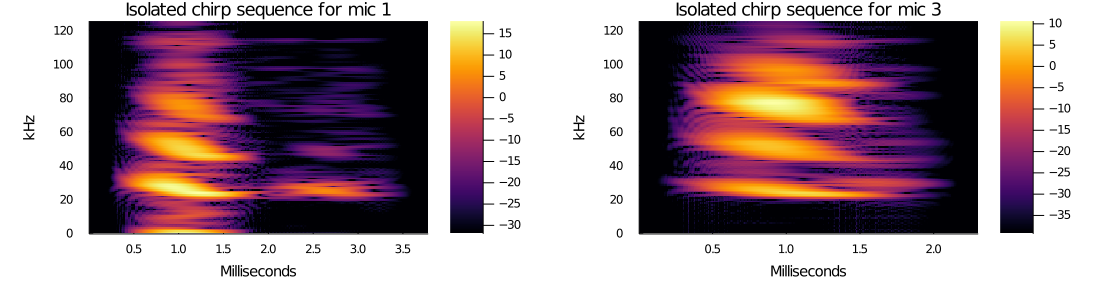

In [91]:
seq_idx = randint(length(chirp_sequences));
chirp_seq = chirp_sequences[seq_idx];
(@printf "Sequence number: %d\n" seq_idx);

pad_len = 300;
offsets = computemelodyoffsets(chirp_sequences[seq_idx], PEAK_THRESH; chirp_kwargs...)
Y, mics = getchirpsequenceY(chirp_seq, offsets, pad_len);
plotchirpsequence(chirp_seq; plot_spectrogram=true)

Chirp Lengths (ms): [1.508, 1.276]


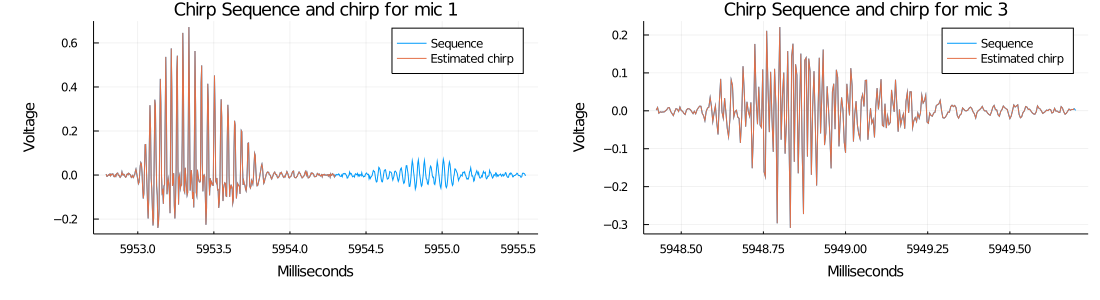

In [92]:
plotestimatedchirps(chirp_seq, PEAK_THRESH; chirp_kwargs...)

### Initial condition

We can give the optimization algorithm a "warm start" using the estimated chirps from Step 4.
To do so, we estimate the chirp and impulse response for each microphone, and choose the microphone that produces the sparsest impulse response.

There are two different methods for finding the initial condition. The first, and recommended, is to use `getinitialconditionsnr`, which chooses the microphone with the highest SNR to provide the initial guess for $\mathbf{x}$. The second, using `getinitialconditionsparsity`, is to choose whichever microphone provides the sparsest estimates of the impulse responses.

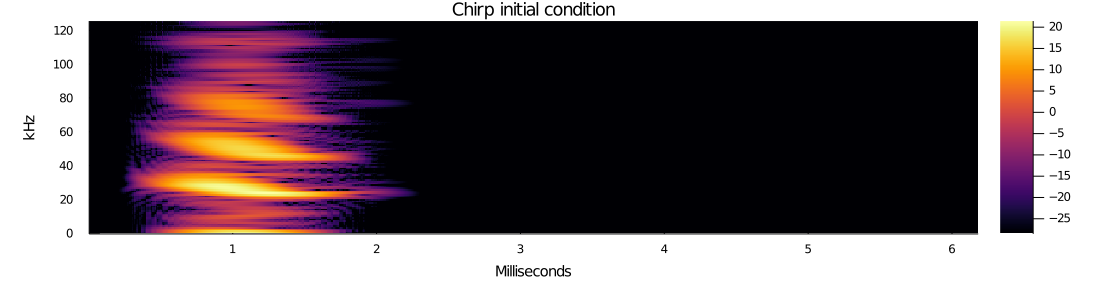

In [93]:
X_init, H_init, longest_chirp = getinitialconditionsnr(Y, chirp_seq, mics, PEAK_THRESH)
plotSTFTtime(X_init; title="Chirp initial condition", nfft=256, noverlap=255)

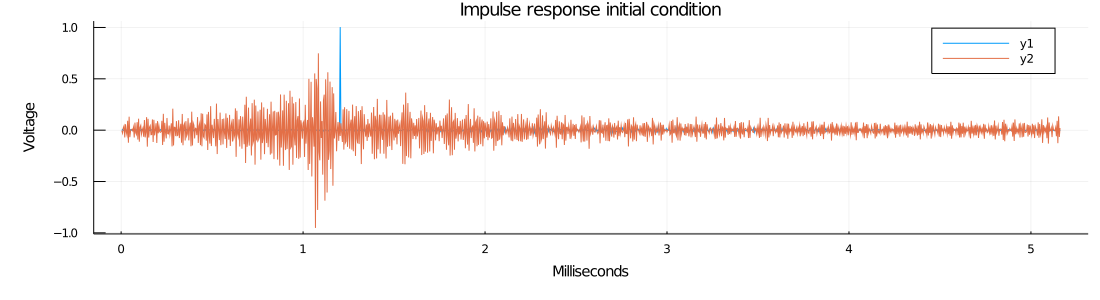

In [94]:
plotmicdata(H_init, title="Impulse response initial condition")

### Optimization parameters
You can choose how much to weight each term in the optimization problem: think of these parameters as percentages of how important each component of the optimization problem is, though they need not sum up to 100. The following cell has some reasonable values.

In [95]:
### CONFIGURABLE PARAMETERS ###

DATA_FITTING_WEIGHT = 60; ## Making H * X close to Y
H_SPARSITY_WEIGHT = 10; ## Looking for sparse impulse responses. Generally, should be weighted pretty low.
MELODY_WEIGHT = 50; ## Maing melody of the chirp close to the result of findmelody

How spaced out should the spectrogram windows be? A good heuristic is to have 20 windows over the length of the chirp.

In [96]:
STFT_STRIDE = Int64(ceil(longest_chirp / 20));

How long to run the optimization algorithm for? 10000 iterations seems to work pretty well; running it for longer may cause the algorithm to converge better if it doesn't converge well already (presumably, giving better results), and running for fewer iterations makes it faster.

In [97]:
### CONFIGURABLE PARAMETER ###

MAX_ITER=10000;

### Optimization

Run the following cell to see what the optimization algorithm thinks the bat vocalization was (along with the impulse responses of each microphone for the given chirp)!

In [98]:
X_opt, H_opt, max_chirp_len = optimizePALM(chirp_seq, Y, H_init, X_init, PEAK_THRESH,
                        DATA_FITTING_WEIGHT, H_SPARSITY_WEIGHT, MELODY_WEIGHT;
                        max_iter=MAX_ITER, nfft=256, stft_stride=STFT_STRIDE);

[Initial] Average squared error = 2.3351e-32; H sparsity loss = 58.602910
[Iter 1000] Average squared error = 1.1121e-03; H sparsity loss = 1.575237
[Iter 2000] Average squared error = 1.0592e-03; H sparsity loss = 1.302094
[Iter 3000] Average squared error = 1.0456e-03; H sparsity loss = 1.171537
[Iter 4000] Average squared error = 1.0397e-03; H sparsity loss = 1.088445
[Iter 5000] Average squared error = 1.0364e-03; H sparsity loss = 1.029039
[Iter 6000] Average squared error = 1.0343e-03; H sparsity loss = 0.983902
[Iter 7000] Average squared error = 1.0329e-03; H sparsity loss = 0.948191
[Iter 8000] Average squared error = 1.0319e-03; H sparsity loss = 0.918973
[Iter 9000] Average squared error = 1.0310e-03; H sparsity loss = 0.894496
[Iter 10000] Average squared error = 1.0303e-03; H sparsity loss = 0.873642


### Optimization Results: Vocalization

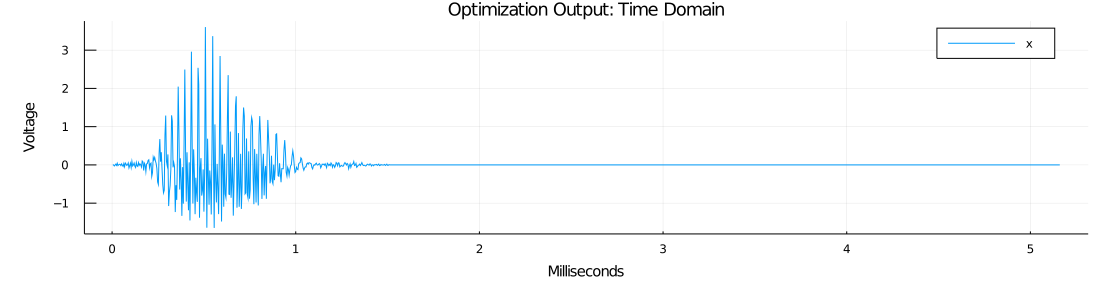

In [99]:
plotmicdata(X_opt, label="x", title="Optimization Output: Time Domain")

#### Play the estimated chirp, slowed down by a factor of 15

In [100]:
using WAV;
SLOW_DOWN_FACTOR = 15;
wavplay(X_opt ./ max.(abs.(X_opt)), round(FS / SLOW_DOWN_FACTOR));

#### Frequency-Domain Results: optimization algorithm estimation of the vocalization

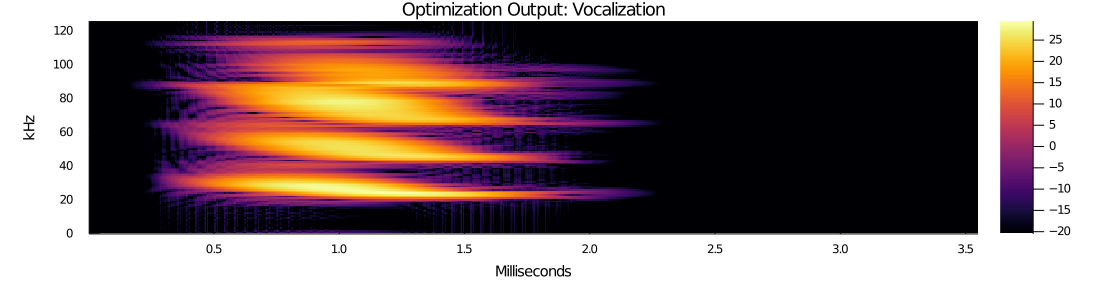

In [101]:
plotSTFTtime(X_opt[1:max_chirp_len+255], title="Optimization Output: Vocalization", noverlap=255)

#### For comparison: vocalization initial condition

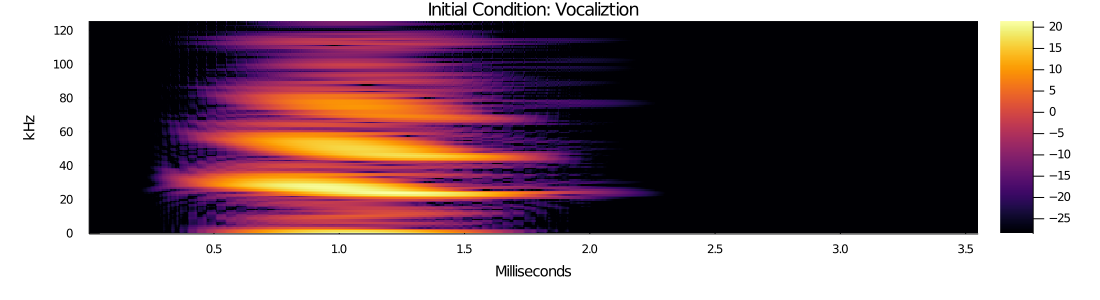

In [102]:
plotSTFTtime(X_init[1:max_chirp_len+255], title="Initial Condition: Vocaliztion", noverlap=255)

### Optimization Results: Impulse Responses

**Note** sometimes there might be significant peaks at the *end* of the impulse responses. This is not unexpected! We are actually using the circular convolution of the vocalization and impulse response to estimate the microphone data, so those peaks at the end can be thought of as occuring before the pictured start of the impulse response.

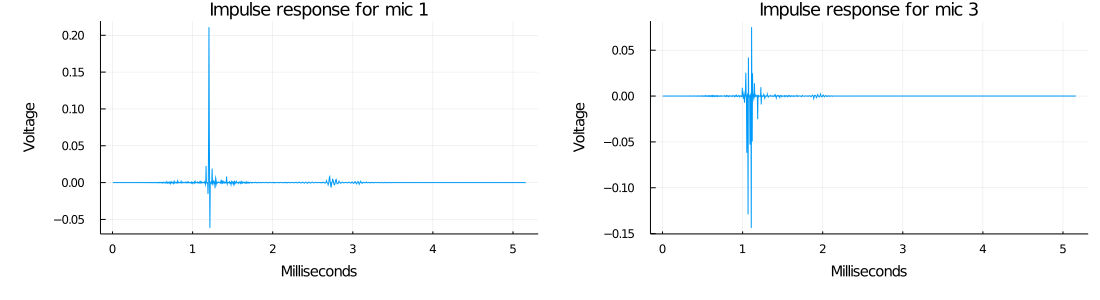

In [103]:
K=size(Y, 2);
plots = Matrix(undef, 1, 5);
for i=1:K
    plots[i] = plotmicdata(H_opt[:, i], title=(@sprintf "Impulse response for mic %d" mics[i]), legend=false)
end
plots[K+1] = myplot([0, 0], legend=false, title="Blank Plot", xlabel="", ylabel="");

num_rows = Int64(floor(K + K%2) / 2);
plot(plots[1:num_rows*2]..., layout=(num_rows, 2), size=(1100, num_rows*300))

### Optimization Results: Estimation Error

How far is $\mathbf{x} * \mathbf{h}_k$ from the actual microphone data? For the right choise of optimization parameters, the estimation error (orange curve plotted below) should be insignificant (same order of magnitude as noise).

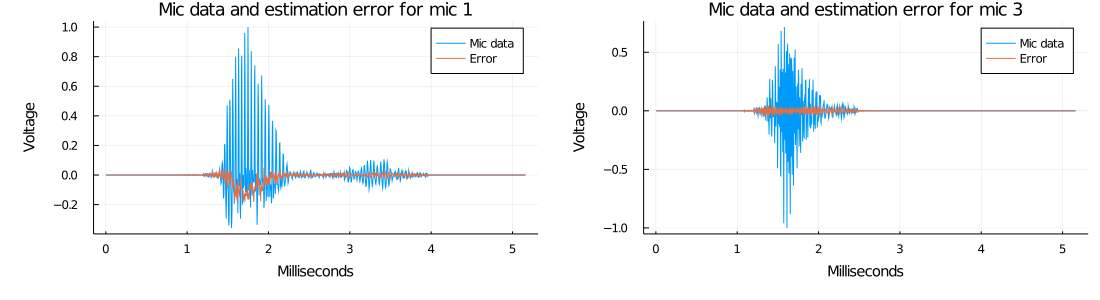

In [104]:
K=size(Y, 2);
plots = Matrix(undef, 1, 5);
Y_hat = circconv(X_opt, H_opt);
for i=1:K
    plots[i] = plotmicdata([Y[:, i] Y_hat[:, i]-Y[:, i]], title=(@sprintf "Mic data and estimation error for mic %d" mics[i]), label=["Mic data" "Error"])
end
plots[K+1] = myplot([0, 0], legend=false, title="Blank Plot", xlabel="", ylabel="");

num_rows = Int64(floor(K + K%2) / 2);
plot(plots[1:num_rows*2]..., layout=(num_rows, 2), size=(1100, num_rows*300))

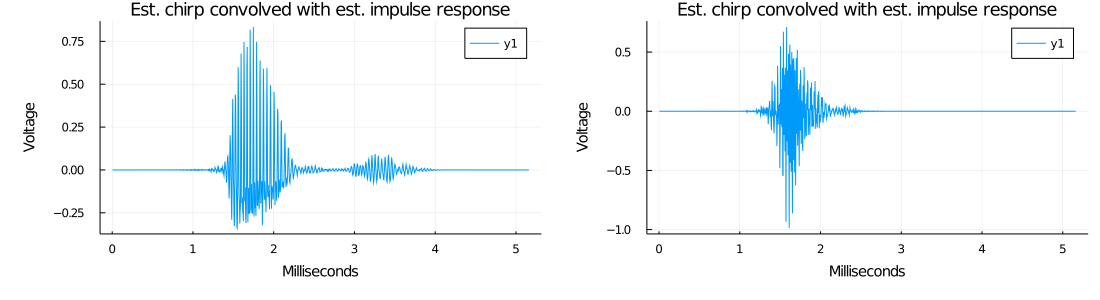

In [105]:
K=size(Y, 2);
plots = Matrix(undef, 1, 5);
for i=1:K
    plots[i] = plotmicdata(Y_hat[:, i], title="Est. chirp convolved with est. impulse response")
end
plots[K+1] = myplot([0, 0], legend=false, title="Blank Plot", xlabel="", ylabel="");

num_rows = Int64(floor(K + K%2) / 2);
plot(plots[1:num_rows*2]..., layout=(num_rows, 2), size=(1100, num_rows*300))